<a href="https://colab.research.google.com/github/wqw547243068/school-of-ai-beijing/blob/master/code/fastai_1_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI深度学习
- 【2019-04-29】王奇文，wqw547243068@163.com，School of AI
## 第一课 宠物图像分类 Lesson 1-What's your pets ?
- 内容：从零开始，完成图像分类任务，并达到世界领先水平
- 数据集：[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)，包含12种猫和25种狗
- 任务：区分所有物种，即37分类
- 效果：201年，[O. M. Parkhi et al](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf).论文里用了一个复杂模型，先区分图像，再分清头和身体，最后取得成绩是：分类准确率59.21%
- 我们能做到什么程度呢？拭目以待！

## 环境准备
- 确保fastai环境是最新的
- curl命令从远程下载bash脚本,，并通过管道(|)命令执行，内容是：
```bash
#!/bin/bash
# 主要功能：fastai本地环境部署
if [ ! -e /content/models ]; then
        mkdir -p /root/.torch/models
        mkdir -p /root/.fastai/data
        ln -s /root/.torch/models /content
        ln -s /root/.fastai/data /content
        rm -rf /content/sample_data/
fi
```

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


- 以下3行代码是每个jupyter笔记都需要添加的，作用是：
   - 确保调用的库自动更新——autoreload
   - 加载画图程序，直接嵌入笔记本——matplotlib

In [0]:
%reload_ext autoreload
%autoreload 2 # 每隔2s自动刷新库
%matplotlib inline # 开启matplotlib嵌入功能，直接显示在笔记内

## fastai包导入
- fastai是在pytorch 1.0基础上构建的深度学习工具包
- 特点：开发速度快，直接使用最先进的模型

In [0]:
from fastai.vision import * # 导入所有子包
from fastai.metrics import error_rate # 评估函数：错误率

## 设置batch_size
- bs是每个喂给模型的样本量，数字越大，越吃内存
- 如果运行过程中，内存溢出，请将bs值调小
- bs数值符合2^n，为什么？
   - 计算机底层设计有关，电脑的CPU/GPU处理的都是二进制，不管32位还是64位，为了最大限度利用起来，需要设置成2的幂级数形式
   - <font color='blue'>计算机底层设计有关，电脑的CPU/GPU处理的都是二进制，不管32位还是64位，为了最大限度利用起来，需要设置成2的幂级数形式</font>

In [0]:
# bs = 64
# bs = 16
bs = 8

## 数据准备
- 下载图像数据集到本地
- 数据拆分：特征+标签

In [0]:
# URLs包含了很多有用的数据集地址，如mnist
#URLs.MNIST
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [0]:
# 从亚马逊云上下载数据，宠物数据集地址：https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'
path = untar_data(URLs.PETS) # 解压缩
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

- path包包含了大量linux本地操作命令，如：ls、mkdir等

In [0]:
path.ls() # 查看当前目录下的文件
#!pwd # 除了调用path子包，还可以加!直接调用linux命令

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

## 数据读取
- 数据集分成图片及标签，分别对应images和annotation目录
- 此处可以通过linux命令计算图片数目
- 用python的PIL和matplotlib显示图片内容

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
#!ls $path_img # 显示目录下的图片文件: beagle_194.jpg和beagle_194.mat
!ls $path_img | wc -l # 显示文件数目7393
!ls $path_img | awk -F'.' '{print $2}'|sort|uniq -c
!echo "显示annotation目录内容："
!ls $path_anno

7393
      1 
显示annotation目录内容：
list.txt  README  test.txt  trainval.txt  trimaps  xmls


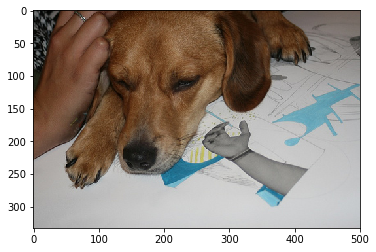

In [0]:
#!ls $path_img | head
from matplotlib import pyplot as plt
from PIL import Image

img_file = '%s/beagle_194.jpg'%(path_img) # 随便选一张图片
plt.imshow(Image.open(img_file))

- 通过fastai内置方法读取图像，显示5张

In [0]:
fnames = get_image_files(path_img) # 将所有文件列表读入列表fnames
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_184.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_56.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_62.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_127.jpg')]

In [0]:
np.random.seed(2) # 设置随机种子，方便batch分组时尽量随机
pat = r'/([^/]+)_\d+.jpg$' # 正则表达式，只提取jpg文件，剔除mat文件

### 思考
- 监督学习的特征（feature，输入）是有了，37种哺乳动物的图片，可是标签（label，输出）在哪儿？

- 答案：label在图片名字中，这就是正则表达式的功劳！

### 继续看看猫猫狗狗
- data是fastai内置的数据类型，包含多种方法

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

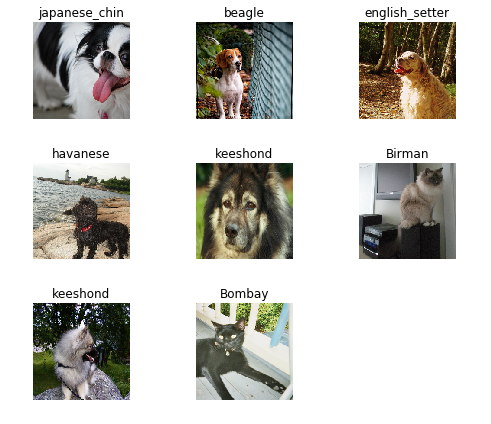

In [0]:
data.show_batch(rows=3, figsize=(7,6)) # 通过fastai内置方法显示图片

In [0]:
print(data.classes) 
len(data.classes), data.c # 显示不同种类的猫狗数目

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 建立神经网络模型
- 此处直接通过一条命令创建传说中的resnet34 <font color='red'>resnet34</font>
- 注意：解决问题前，一定要先充分理解数据！

### 听说你不懂CNN？
- 大佬叫你过去听课：[Yann LeCun连发三弹：人人都懂的深度学习基本原理](https://www.leiphone.com/news/201612/Sjkmer9Kto5ILxFk.html?utm_source=itdadao&utm_medium=referral)
- mnist手写数字识别[3D交互体验](http://scs.ryerson.ca/~aharley/vis/conv/)
- ![cnn](https://static.leiphone.com/uploads/new/article/740_740/201612/58415ac7a72c6.gif)

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 95033039.81it/s]


- 查看resnet网络结构：很复杂。。。
- learn是什么样的对象？
   - learn有哪些可用方法？——learn.后按Tab键-<font color='red'>Tab键</font>，会自动提示可用方法
   - learn.fit_one_cycle是什么意思？——后面加问号<font color='red'>?</font>执行，就能看到方法介绍

In [0]:
learn.model # 显示网络结构
# 显示方法含义，后面加问号！结果：Fit a model following the 1cycle policy. 单周期策略的模型训练方法
learn.fit_one_cycle?

## 模型训练
- 激动人心的时刻到了！训练神经网络模型！

In [0]:
learn.fit_one_cycle(4) # 训练4个epoch（周期）

epoch,train_loss,valid_loss,error_rate,time
0,1.109016,0.484587,0.165088,01:41
1,0.778592,0.321674,0.100135,01:41
2,0.592410,0.262169,0.081191,01:44
3,0.483396,0.242214,0.076455,01:41


## 模型保存
- save方法用于保存模型

In [0]:
learn.save('stage-1')

## 效果分析
- 哪些样本最差，长什么样子

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses() ## 看看那些样本最差
len(data.valid_ds)==len(losses)==len(idxs)

True

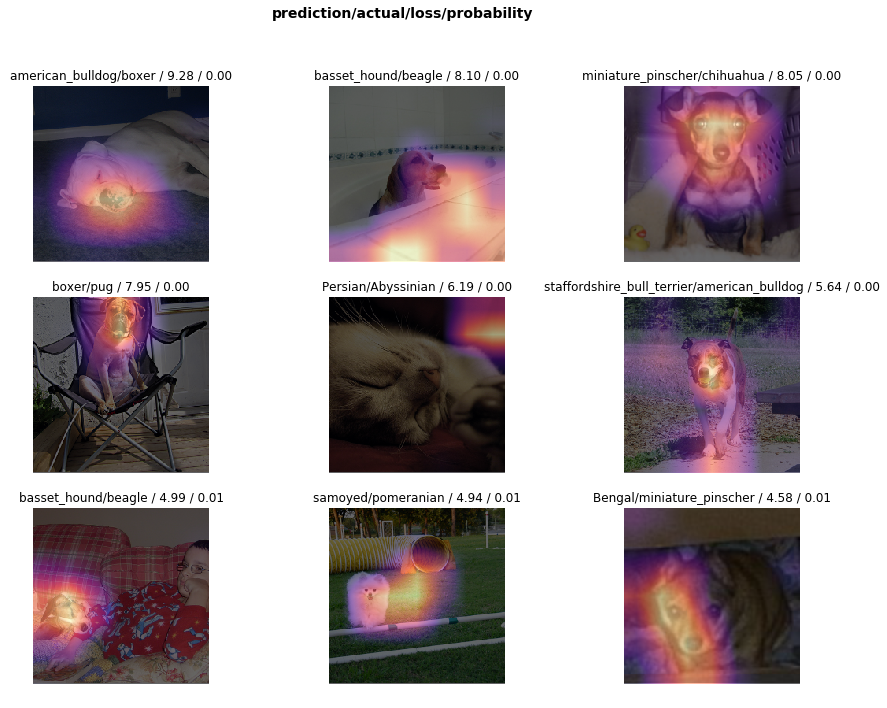

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

- 显示某方法的说明，等同于加问号

In [0]:
doc(interp.plot_top_losses)

## 模型评估
- 由于是分类问题，这里采用模糊矩阵
- 如果是回归问题，需要采样别的指标，如MAE,MSE等

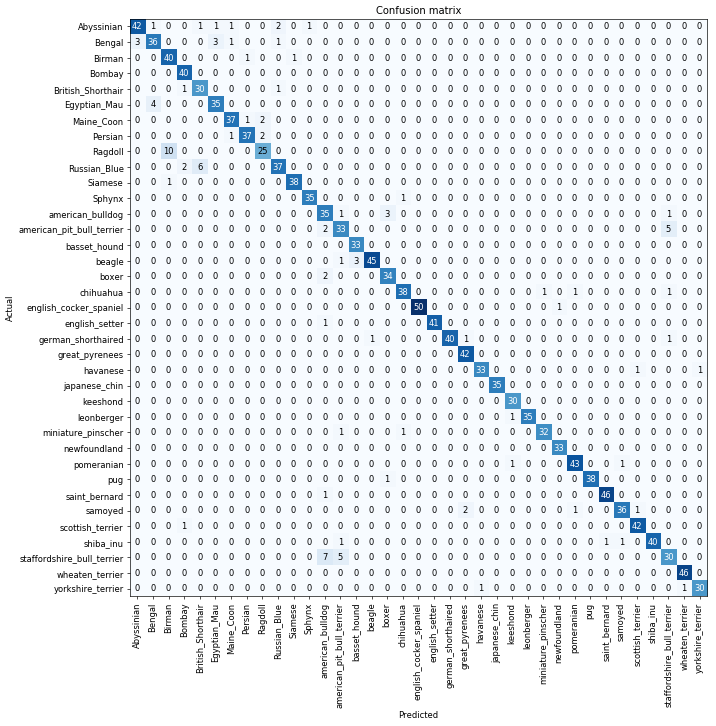

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

### 模糊矩阵
- 横轴是所有N个类目，对应groud truth真值；纵轴也是N个，表示预测的类目——对称矩阵
- 如果大部分样本越集中在对称轴上（颜色深），效果越好

In [0]:
interp.most_confused(min_val=2) #最难分的是哪些样本

[('Ragdoll', 'Birman', 10),
 ('staffordshire_bull_terrier', 'american_bulldog', 7),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('american_bulldog', 'boxer', 3),
 ('beagle', 'basset_hound', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2)]

## 效果迭代
- 模型训练完成后，默认“冻结”freeze
- 如果需要继续训练，先执行“解冻”unfreeze
- 注意：模型效果是错误率13.3%，也就是正确率86.7%！

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.982449,0.445620,0.133288,02:27


In [0]:
learn.load('stage-1');

## 模型调优
- 神经网络超参很多：网络结构、层数、激活函数、bs、学习率等

### 方法一：学习率
- 如果精力有限，就先调最重要的参数——学习率
- 找到好的学习率后，更新到模型，重新训练

In [0]:
learn.lr_find() # 查找最合适的学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


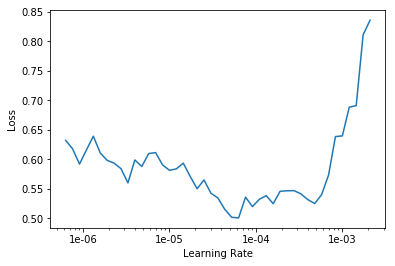

In [0]:
learn.recorder.plot() # 分析学习率取什么值最好

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4)) # 更新学习率，重新训练

epoch,train_loss,valid_loss,error_rate,time
0,0.435095,0.238926,0.072395,02:26


### 方法二：更改batch_size

In [0]:
learn.save('stage-2')

In [0]:
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),size=299, bs=bs//2).normalize(imagenet_stats)

### 方法三：升级模型
- resnet34→resnet50

In [0]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 25443451.98it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


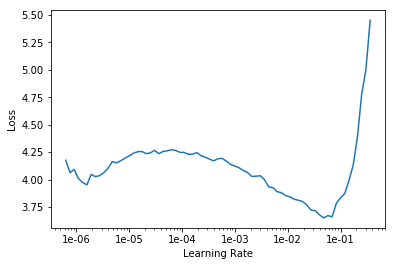

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.061286,0.276833,0.086604,04:34


In [0]:
learn.save('stage-1-50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.745421,0.249251,0.081191,06:07


In [0]:
learn.save('stage-2-50')

## 思考
- 错误率8.1%，也就是正确率91.9%！高于之前的87%
   - 问题：为什么resnet50优于resnet34？
   - 答案：50层的网络比34层复杂，学习能力更强
- 还能继续提升吗？——靠你自己了！加油

![addoil](https://s.yimg.com/ny/api/res/1.2/unSXX6m.mrIFWzJ99gcgSQ--~A/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9NTAw/http://media.zenfs.com/zh-Hant-HK/homerun/yahoocontent.nmg.com.hk/fe7573cef8ec3f73c95d0b0b54f186b7)